In [1]:
import common.input as input
import algorithm.lightweight.coreset as kmeanscoreset
import common.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns
np.random.seed(13455)

In [2]:
def gen_linear_dataset(xmin=-1, xmax=1, ymin=-1, ymax=1, ndim=2, N=1000):
    xdata = np.random.rand(N, ndim)
    xdata[:,0] = xdata[:,0] * (xmax - xmin) - (xmax+xmin)/2
    xdata[:,1] = xdata[:,1] * (ymax - ymin) - (ymax+ymin)/2
    labels = xdata[:,0]<xdata[:,1]
    return xdata, labels
    

def inscribed_circle_dataset(N=1000, diameter=1, sidelen=2):
    xdata = sidelen * (np.random.rand(N, 2) - .5)
    circleinds = xdata[:,0] ** 2 + xdata[:,1] ** 2 <= diameter/2
    c0data = xdata[~circleinds]
    c1data = xdata[circleinds]
    labels = circleinds
    return c0data, c1data, labels

CASE 1: k-means based corset algorithms are suboptimal
***********************
Linear Dataset
N c0 = 488
N c1 = 512
***********************
Circumscribed Dataset
N c0 = 1198
N c1 = 802


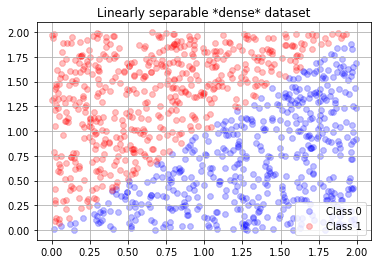

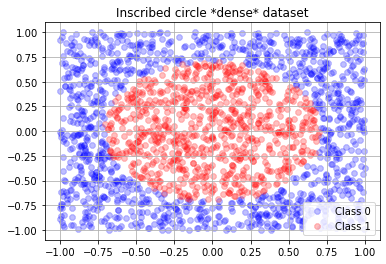

In [3]:
xdata, labels = gen_linear_dataset()
# plt.figure(figsize=(2,4), dpi=300)
# plt.subplot(2,1,1)
plt.figure()
plt.scatter(xdata[labels==0, 0], xdata[labels==0, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.scatter(xdata[labels==1, 0], xdata[labels==1, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.title('Linearly separable *dense* dataset')
plt.grid()
plt.legend()

x0square, x1circle, inscribedlabels = inscribed_circle_dataset(N=2000)
# plt.subplot(2,1,2)
plt.figure()
plt.scatter(x0square[:, 0], x0square[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.scatter(x1circle[:, 0], x1circle[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.title('Inscribed circle *dense* dataset')
plt.grid()
plt.legend()

print('CASE 1: k-means based corset algorithms are suboptimal')
print('***********************')
print('Linear Dataset')
print(f'N c0 = {sum(~labels)}')
print(f'N c1 = {sum(labels)}')

print('***********************')
print('Circumscribed Dataset')
print(f'N c0 = {sum(~inscribedlabels)}')
print(f'N c1 = {sum(inscribedlabels)}')



In [4]:
def xor_network_dataset(samps_perclass=1000, cov=.1):
    c0 = np.vstack([np.random.multivariate_normal(mean=[0, 0], cov = cov * np.eye(2),size=samps_perclass),
                np.random.multivariate_normal(mean=[1, 1], cov = cov * np.eye(2),size=samps_perclass)])
    c1 = np.vstack([np.random.multivariate_normal(mean=[0, 1], cov = cov * np.eye(2),size=samps_perclass),
                np.random.multivariate_normal(mean=[1, 0], cov = cov * np.eye(2),size=samps_perclass)])
    return c0, c1

def unimodal_gaussian_classconditional_data(mu0=0, mu1=1, ndim=2, sigma0=1, sigma1=1, N=None, nx0=None, nx1=None):
        if N is not None and (nx0 is not None or nx1 is not None):
            print('Error: Either specify nx0 and nx1, the number of points in each class, or specify N for equaly likely class prior')
        if nx0 is None:
            nx0 = int(N/2)
            nx1 = nx0
        x0data = sigma0 * np.random.randn(nx0, ndim) + mu0
        x1data = sigma1 * np.random.randn(nx1, ndim) + mu1
        return x0data, x1data

CASE 2: k-means based coreset algorthms are appropriate
***********************
Unimodal class conditionals
N c0 = 500
N c1 = 500
***********************
XOR Data
N c0 = 500
N c1 = 500


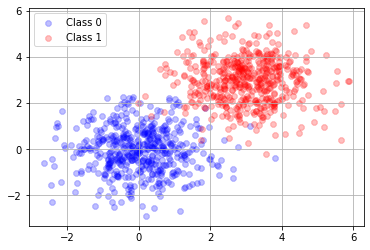

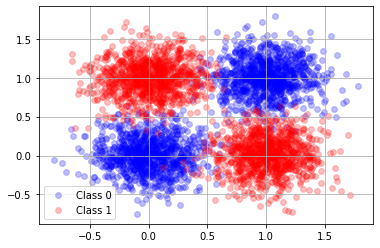

In [5]:
    
print('CASE 2: k-means based coreset algorthms are appropriate')

plt.figure()
N=1000
x0data, x1data = unimodal_gaussian_classconditional_data(N=1000, mu1=3)
plt.scatter(x0data[:, 0], x0data[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.scatter(x1data[:, 0], x1data[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.grid()
plt.legend()
print('***********************')
print('Unimodal class conditionals')
print(f'N c0 = {int(N/2)}')
print(f'N c1 = {int(N/2)}')

plt.figure()
N=1000
xor0, xor1 = xor_network_dataset(cov=.05)
xordata = np.vstack([xor0, xor1])

plt.scatter(xor0[:, 0], xor0[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.scatter(xor1[:, 0], xor1[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.grid()
plt.legend()

print('***********************')
print('XOR Data')
print(f'N c0 = {int(N/2)}')
print(f'N c1 = {int(N/2)}')

ORIGINAL COST:	 4437.594014517716


100%|██████████| 250/250 [00:05<00:00, 49.50it/s]


Empirical Epsilon:	 0.0732828434852421
Mean Cost:	 4145.10248024856


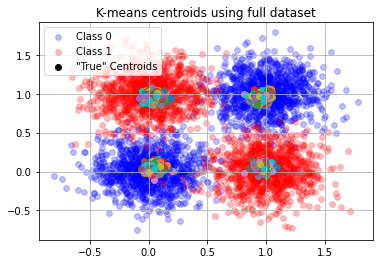

In [6]:
EPSILON=.1
K=4
from sklearn.cluster import KMeans
import tqdm
kmcset = kmeanscoreset.LightweightCoreset(xordata, K, EPSILON)

plt.figure()
plt.scatter(xor0[:, 0], xor0[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.scatter(xor1[:, 0], xor1[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.title('K-means centroids using full dataset')
plt.grid()

kmeans = KMeans(n_clusters=K, random_state = 0).fit(X=xordata)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='k', label='"True" Centroids')
orig_cost = utils.cost_function(xordata, kmeans.labels_, kmeans.cluster_centers_)
print('ORIGINAL COST:\t', orig_cost)
plt.legend()

def test_coreset(K, coreset, weights, origdata):
    kmeans = KMeans(n_clusters=K, random_state = 0).fit(X=coreset, sample_weight=weights)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1])
    cost = utils.cost_function(origdata, kmeans.predict(X=origdata), kmeans.cluster_centers_)
    return cost


coreset_costs = []
for i in tqdm.tqdm(range(250)):
    coreset, weights = kmcset.compute()
    _cost = test_coreset(K, coreset, weights, xordata)
#     if i==0:
#         plt.figure()
#         plt.scatter(coreset[:, 0], coreset[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
#         plt.title('Example Coreset, |Data|=%d ,|Coreset|=%d' % (len(xordata), len(coreset)))
#         plt.grid()
#         plt.figure()
#         plt.scatter(xor0[:, 0], xor0[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
#         plt.scatter(xor1[:, 0], xor1[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
#         plt.title('Centroids found using Coresets(Over all 100 runs)')
#         plt.grid()
    coreset_costs.append(_cost)
#     results.append()
# print(np.mean(coreset_costs))
epsilons = np.abs(np.array(coreset_costs) - orig_cost*np.ones_like(coreset_costs))/orig_cost
print('Empirical Epsilon:\t', np.mean(epsilons))
print('Mean Cost:\t', np.mean(coreset_costs))
# plt.title('Cluster centers found via Coreset')

xorepsilon = np.mean(epsilons)

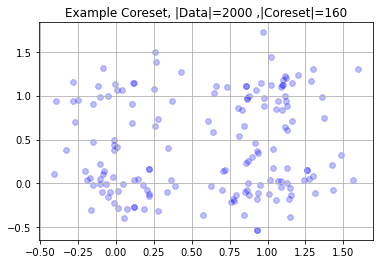

In [7]:
plt.figure()
plt.scatter(coreset[:, 0], coreset[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.title('Example Coreset, |Data|=%d ,|Coreset|=%d' % (2000, len(coreset)))
plt.grid()

Text(0.5, 0, 'Epsilon')

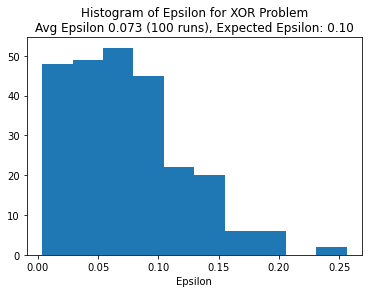

In [8]:
plt.figure()
plt.hist(epsilons)
plt.title('Histogram of Epsilon for XOR Problem\nAvg Epsilon %.3f (100 runs), Expected Epsilon: %.2f' % (np.mean(epsilons), EPSILON))
plt.xlabel('Epsilon')



ORIGINAL COST:	 2694.793054302248


100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


2877.6598610217416
Empirical Epsilon 0.16866188200650464


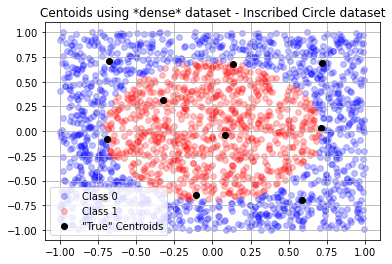

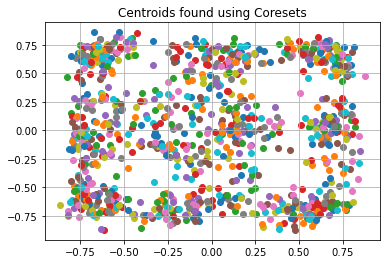

In [9]:
sqcircdata = np.vstack([x0square, x1circle])
EPSILON=.1
K=10
from sklearn.cluster import KMeans
import tqdm
kmcset = kmeanscoreset.LightweightCoreset(sqcircdata, K, EPSILON)

plt.figure()
plt.scatter(x0square[:, 0], x0square[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.scatter(x1circle[:, 0], x1circle[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.title('Centoids using *dense* dataset - Inscribed Circle dataset')
plt.grid()
plt.legend()

kmeans = KMeans(n_clusters=K, random_state = 0).fit(X=sqcircdata)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='k', label='"True" Centroids')
cost = utils.cost_function(sqcircdata, kmeans.labels_, kmeans.cluster_centers_)
print('ORIGINAL COST:\t', cost)
plt.legend()

def test_coreset(K, coreset, weights, origdata):
    kmeans = KMeans(n_clusters=K, random_state = 0).fit(X=coreset, sample_weight=weights)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1])
    cost = utils.cost_function(origdata, kmeans.predict(X=origdata), kmeans.cluster_centers_)
    return cost

plt.figure()
# plt.scatter(x0square[:, 0], x0square[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
# plt.scatter(x1circle[:, 0], x1circle[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.title('Centroids found using Coresets')
plt.grid()
coreset_costs = []
for i in tqdm.tqdm(range(100)):
    coreset, weights = kmcset.compute()
    _cost = test_coreset(K, coreset, weights, sqcircdata)
    coreset_costs.append(_cost)
#     results.append()
print(np.mean(coreset_costs))
epsilons = abs(np.array(coreset_costs) - cost)/cost
print('Empirical Epsilon', np.mean(abs(np.array(coreset_costs)-cost))/cost)
# plt.title('Cluster centers found via Coreset')



Text(0.5, 0, 'Epsilon')

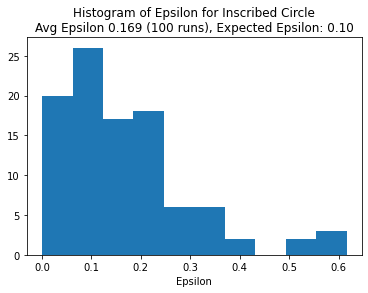

In [10]:
plt.figure()
plt.hist(epsilons)
plt.title('Histogram of Epsilon for Inscribed Circle\nAvg Epsilon %.3f (100 runs), Expected Epsilon: %.2f' % (np.mean(epsilons), EPSILON))
plt.xlabel('Epsilon')



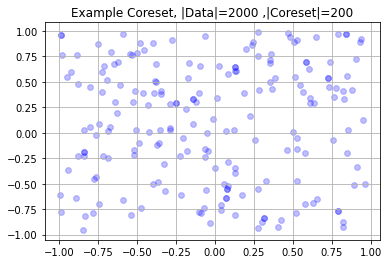

In [11]:
plt.figure()
plt.scatter(coreset[:, 0], coreset[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.title('Example Coreset, |Data|=%d ,|Coreset|=%d' % (2000, len(coreset)))
plt.grid()

ORIGINAL COST:	 1277.624830698021


100%|██████████| 100/100 [00:02<00:00, 35.21it/s]


1223.7980973966767
Empirical Epsilon 0.18373992361109706


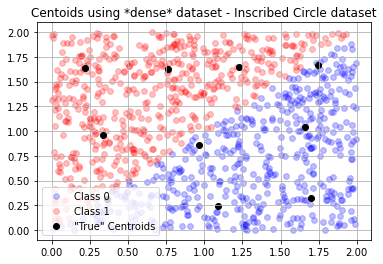

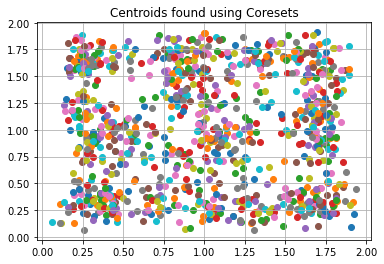

In [12]:
x0data = xdata[labels==0]
x1data = xdata[labels==1]
# xdata = np.vstack([x0square, x1circle])
EPSILON=.1
K=10
from sklearn.cluster import KMeans
import tqdm
kmcset = kmeanscoreset.LightweightCoreset(xdata, K, EPSILON)

plt.figure()
plt.scatter(x0data[:, 0], x0data[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
plt.scatter(x1data[:, 0], x1data[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.title('Centoids using *dense* dataset - Inscribed Circle dataset')
plt.grid()
plt.legend()

kmeans = KMeans(n_clusters=K, random_state = 0).fit(X=xdata)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='k', label='"True" Centroids')
cost = utils.cost_function(xdata, kmeans.labels_, kmeans.cluster_centers_)
print('ORIGINAL COST:\t', cost)
plt.legend()

def test_coreset(K, coreset, weights, origdata):
    kmeans = KMeans(n_clusters=K, random_state = 0).fit(X=coreset, sample_weight=weights)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1])
    cost = utils.cost_function(origdata, kmeans.predict(X=origdata), kmeans.cluster_centers_)
    return cost

plt.figure()
# plt.scatter(x0data[:, 0], x0data[:, 1], color='b', alpha=.25, marker='8', label='Class 0')
# plt.scatter(x1data[:, 0], x1data[:, 1], color='r', alpha=.25,  marker='8', label='Class 1')
plt.title('Centroids found using Coresets')
plt.grid()
coreset_costs = []
for i in tqdm.tqdm(range(100)):
    coreset, weights = kmcset.compute()
    _cost = test_coreset(K, coreset, weights, xdata)
    coreset_costs.append(_cost)
#     results.append()
print(np.mean(coreset_costs))
epsilons = abs(np.array(coreset_costs) - cost)/cost
print('Empirical Epsilon', np.mean(abs(np.array(coreset_costs)-cost))/cost)
# plt.title('Cluster centers found via Coreset')



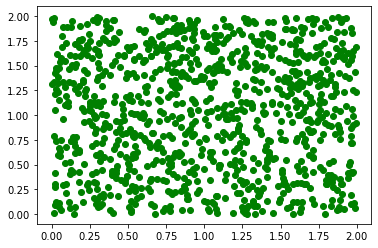

In [13]:
plt.plot(xdata[:,0], xdata[:,1], 'og')